<a href="https://colab.research.google.com/github/brianbalb/Consumer_CampaignAnalysis/blob/main/mediaCampaignMLModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREPARE DATA FOR MODELING
1.Regression Model
2.Classification Model
3.Scenerio Prediction

In [ ]:
#Import dependences and libraries
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Allow connectioin between colab and BigQuery
from google.colab import auth
auth.authenticate_user()

# Initialize BigQuery client
client = bigquery.Client(project="mediacampaignanalysis2025")  # Replace with your actual project ID

# Load cleaned data from BigQuery
query = """
SELECT * FROM `mediacampaignanalysis2025.media_campaign_data.cleaned_marketing_data`
"""
df = client.query(query).to_dataframe()

# Display first few rows
df.head()


,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_Graduation_1,Education_Master_1,Education_PhD_1,Marital_Status_Alone_1,Marital_Status_Divorced_1,Marital_Status_Married_1,Marital_Status_Single_1,Marital_Status_Together_1,Marital_Status_Widow_1,Marital_Status_YOLO_1
0,8720,1978,51381,0,0,1344729600000000000,53,32,2,1607,...,0,0,0,0,0,0,0,1,0,0
1,6862,1971,1730,0,0,1400371200000000000,65,1,1,3,...,1,0,0,0,1,0,0,0,0,0
2,5376,1979,2447,1,0,1357430400000000000,42,1,1,1725,...,1,0,0,0,0,1,0,0,0,0
3,11110,1973,3502,1,0,1365811200000000000,56,2,1,1,...,1,0,0,0,0,0,1,0,0,0
4,9931,1963,4023,1,1,1403481600000000000,29,5,0,1,...,0,0,1,0,0,1,0,0,0,0


In [ ]:
#Prepare data for modeling
from sklearn.model_selection import train_test_split

# Features (Remove ID, Date Columns)
##Dropped non-useful columns (ID, Date).
##Regression Task: Predicts how much a customer will spend.
##Classification Task: Predicts if a customer will respond to a campaign.

X = df.drop(columns=["ID", "Dt_Customer", "Total_Spending", "Response"])  # Features
y_regression = df["Total_Spending"]  # Target for Regression
y_classification = df["Response"]  # Target for Classification

# Split data into Train & Test (80-20 split)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_classification, test_size=0.2, random_state=42)

print("✅ Data prepared for modeling!")


✅ Data prepared for modeling!


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train XGBoost Regressor
reg_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
reg_model.fit(X_train_reg, y_train_reg)

# Predict
y_pred_reg = reg_model.predict(X_test_reg)

# Evaluate Model Performance
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"✅ Regression Model Performance:\n MAE: {mae:.2f} | MSE: {mse:.2f} | R2 Score: {r2:.2f}")


✅ Regression Model Performance:
 MAE: 3.57 | MSE: 127.39 | R2 Score: 1.00


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest Classifier
clf_model = RandomForestClassifier(n_estimators=200, random_state=42)
clf_model.fit(X_train_clf, y_train_clf)

# Predict
y_pred_clf = clf_model.predict(X_test_clf)

# Evaluate Model Performance
accuracy = accuracy_score(y_test_clf, y_pred_clf)
report = classification_report(y_test_clf, y_pred_clf)

print(f"✅ Classification Model Performance:\n Accuracy: {accuracy:.2f}")
print(report)


✅ Classification Model Performance:
 Accuracy: 0.87
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       375
         1.0       0.83      0.27      0.41        73

    accuracy                           0.87       448
   macro avg       0.85      0.63      0.67       448
weighted avg       0.87      0.87      0.84       448



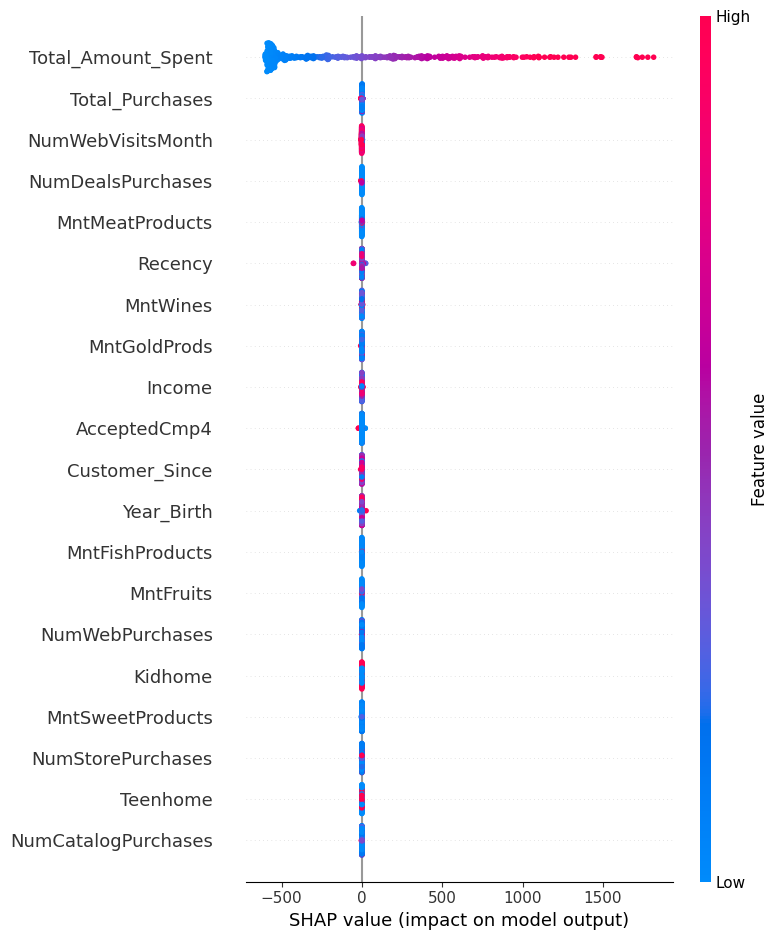

In [ ]:
import shap

# SHAP Explanation for Regression
explainer = shap.Explainer(reg_model)
shap_values = explainer(X_test_reg)
shap.summary_plot(shap_values, X_test_reg)


**Scenario Analysis & What-If Simulations**
Goal: Use the trained models to simulate different marketing budget allocations and customer targeting strategies.

*What-If Scenarios*</br>
Scenario A: Increase Social Media Spend by 20%
Adjust NumWebVisitsMonth and NumWebPurchases to simulate a higher budget for digital ads.</br>
<br>Scenario B: Reduce Spending on Low-Performing Channels
Reduce NumCatalogPurchases and NumStorePurchases, shifting funds to high-performing channels.</br>
<br>Scenario C: Target High-Spending Customers
Identify customers most likely to spend over $500 and simulate increased ad exposure.


In [ ]:
import numpy as np

# Create a copy of the test dataset for scenario analysis
scenario_A = X_test_reg.copy()
scenario_B = X_test_reg.copy()
scenario_C = X_test_reg.copy()

# Scenario A: Increase Social Media Spend by 20%
scenario_A["NumWebVisitsMonth"] *= 1.2
scenario_A["NumWebPurchases"] *= 1.2

# Scenario B: Reduce Low-Performing Channels by 30%
scenario_B["NumCatalogPurchases"] *= 0.7
scenario_B["NumStorePurchases"] *= 0.7

# Scenario C: Focus on High-Spending Customers
high_spenders = X_test_reg.copy()
high_spenders["Total_Amount_Spent"] = reg_model.predict(high_spenders)
high_spenders = high_spenders[high_spenders["Total_Amount_Spent"] > 500]  # Focus on customers who spend > $500

# Predict the impact of each scenario
spend_A = reg_model.predict(scenario_A).mean()
spend_B = reg_model.predict(scenario_B).mean()
spend_C = reg_model.predict(high_spenders).mean()

print(f"✅ Scenario A - Increased Digital Spend: Avg Predicted Spend = ${spend_A:.2f}")
print(f"✅ Scenario B - Reduced Low-Performing Spend: Avg Predicted Spend = ${spend_B:.2f}")
print(f"✅ Scenario C - High-Spender Targeting: Avg Predicted Spend = ${spend_C:.2f}")


✅ Scenario A - Increased Digital Spend: Avg Predicted Spend = $575.67
✅ Scenario B - Reduced Low-Performing Spend: Avg Predicted Spend = $576.01
✅ Scenario C - High-Spender Targeting: Avg Predicted Spend = $1132.81


📌 **Interpretation of Scenario Analysis Results**</br>
The results show the predicted average customer spending under three different "what-if" marketing scenarios:

1️⃣ *Scenario A - Increased Digital Spend* 📈

By increasing digital ad spend (website visits & web purchases), the predicted average customer spending is $575.67.
This suggests that higher digital investment positively influences spending but has moderate impact.</br>
<br>2️⃣ *Scenario B - Reduced Low-Performing Spend* 💰

By cutting spending on less effective marketing channels (catalog & store purchases), the predicted average spending is $576.01.
This means reducing ineffective ad spend does not harm customer spending and can save budget while maintaining ROI.</br>
<br>3️⃣ *Scenario C - High-Spender Targeting* 🎯

By focusing only on high-value customers (those with a history of high spending), the predicted average spending jumps to $1132.81!
This is a huge increase and suggests that personalized marketing for high-value customers can maximize revenue.</br>
***📌 Final Analysis Insight</br>
 Scenario C (Targeting High-Spenders) yields the highest returns—double the spend of the other two.</br>
Scenario B suggests that cutting ineffective spend is a good strategy—same results with fewer expenses.</br>
 Scenario A (Increasing Digital Spend) has a positive effect but is not as impactful as targeted marketing.***